# Project: Medical Appointments

# Introduction 

This case study focus on investigating factors that determine patient's attendance to medical appointment. The research is based on a real world dataset that was collected by stakeholders of a hospital where people would book doctor's appointment, receieve all instructions, and fail to show-up. The hospital's main interest was to devise a model that could predict if a person would show up or not. This project adopt visualization, and statistical tests to deliver insights on how various factors in the data relate with appointment attendance(dependent variable, no_show) and answer the following questions:

### Research Questions 

1. What day of the week has the highest proportion of appointments?
2. Does day of the week determine whether patient will show up?
3. Does attendance depend on appointment month?
4. What month has the highest number appointments?
5. Does attendance depend on age?
6. Does having a scholarship motivate patients to show up for appointment?
7. Is there a relationship between alcoholism and attendance?
8. Is there a relationship between diabetic and attendance?
8. Does gender determine whether a patient will show up?
9. Is attendence depedent of handcup? 

In [1]:
#importing necessary packages and load data from my working directory
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from dateutil import parser #to parse date from string and extract days and months
from scipy.stats import chi2_contingency as chi
%matplotlib inline
df=pd.read_csv('nowshow.csv')
df.head(3) #view first 3 entries

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


# Data Investigation 

In [2]:
#check shape of the data and print dimensions in a single sentense using f string and placeholders
print(f'The data has {df.shape[0]} rows and {df.shape[1]} features')

The data has 110527 rows and 14 features


In [3]:
#check percentage of missing values in each column
#get sum of nulls in each col and divide by total rows then multiply by 100 
(df.isna().sum()/df.shape[0])* 100

PatientId         0.0
AppointmentID     0.0
Gender            0.0
ScheduledDay      0.0
AppointmentDay    0.0
Age               0.0
Neighbourhood     0.0
Scholarship       0.0
Hipertension      0.0
Diabetes          0.0
Alcoholism        0.0
Handcap           0.0
SMS_received      0.0
No-show           0.0
dtype: float64

There were no missing values in the dataset 

In [4]:
#check if there are duplicated in the data and print out using f string and place holder
print(f'There were {df.AppointmentID.duplicated().sum()} duplicates in the data')

There were 0 duplicates in the data


In the context of this study case it was important to check for duplicated using the appointmentID since same ID would mean same exact appointment. 

In [5]:
#check data types for all columns 
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

appointment date and schedule date are not in the right format(datetime), since this analysis will not directly use these columns there was no need to convert them to date objects. However, at the feature engineering stage there is need to parse the appointmentday column to obtain day of the week and month for appointment. 

In [5]:
#change all column labels to lower case and replace - with _
df.columns=df.columns.str.lower()
df.columns=df.columns.str.replace('-','_')
df.columns #confirm changes 

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no_show'],
      dtype='object')

Variables of interest were in the right format and type.

In [7]:
#check summary statisctis for the continous variable (age)
df.age.describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

Half of the people booking appointment are below 37 years. A quater of the client base is 18 years and below. Another quater percent is in the 55-155 age bracket.

The minimum age is -1 (an outlier) since age can only be a positive number. This outlier was fixed by replacing it with the 5th quantile value for age.

In [6]:
#replace lower outlier with the 5th quantile by masking 
lower_q=df.age.quantile(0.05)
outlier=df.age<lower_q
df['age'].mask(outlier,lower_q, inplace=True)

In [7]:
#confirm lower outlier is gone
df.age.describe()

count    110527.000000
mean         37.120912
std          23.059403
min           1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

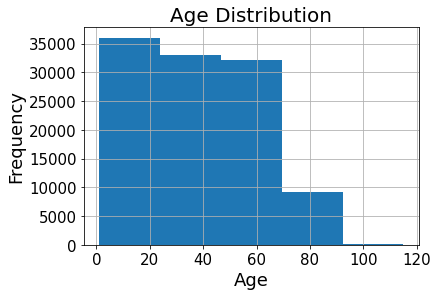

In [9]:
#age distribution
df.age.hist(bins=5);
plt.title('Age Distribution', size=20);
plt.xlabel('Age', size=18);
plt.ylabel('Frequency', size=18);
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

Most of the patients fall in the 1-20 age bracket, patients in 80-120 age bracket are the least. We conclude majority of the appointments were booked for children, youths and young adults. 

# Data Wrangling 

### Feature Engineering 
This is an important stage where new features were derived from existing ones. To answer some of the research questions new variables were needed, day of the week and month. These variables were obtained by parsing appointment date into month and date, hence introducing two features (month and week_day) in the data.

Besides, there was need to convert age into categorical feature so we can see how different age groups respond to attendance.

In [35]:
labs=['Children','Youth','Young Adult','Old Adult', 'Senior']
bins=[0,14,24,35,65,120]
df['age_grp']=pd.cut(df.age, labels=labs, bins=bins)
df.age_grp.value_counts()

Old Adult      44222
Children       23258
Young Adult    15736
Youth          14010
Senior         13301
Name: age_grp, dtype: int64

In [10]:
#parse appointmentDay to obtain day and month name , and store each in a list
#insert day and month list as columns in the dataframe 
day=[]
month=[]

for x in df.appointmentday: 
    day.append(parser.parse(x).strftime('%A'))
    month.append(parser.parse(x).strftime('%B'))
    
df['week_day']=day
df['month']=month

In [13]:
#confirm new variables 
df.head(2)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_grp,week_day,month
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Old Adult,Friday,April
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Old Adult,Friday,April


# Exprolatory Data Analysis 

This part focus on generating insights from the data by using visualization, chi-squre test of indipendence. 


### Chi-Square Test of Indipendence.
In this project, this test was used to check correlation between categorical variables and the indipendent variable (no-show/attendance). The test checks two hypothesis:

H0: X and Y are dependent.


H1: X and Y are indipendent.

We reject H0 if the resulting p-value is greater than 0.05, however, we could use 0.1 to be more confident. In this project, decisions were made at 0.05. 

## Create custom function to create cross table and perform chi-square test

The DRY rule of programming must hold. This function saved me time by avoid repetation. 

In [32]:
#create a cross table and perform chi-square test for indipendence
#test indipendence between variables 
def chi_square(var, var2):
    table=pd.crosstab(index=var, columns=var2)
    print(table)
    print(f'The test p-value is {chi(table)[1]}')
    

## Does gender determine whether a patient will show up?
There are more women than men in the sample, we can infer from graph 1.1 that less than 50% of men and women never showed up for appointment. Besides, we can not conclude what gender has more defaulters due imbalanced sample size. However, we could point out that women are more careful than men on their health matters since more women are booking for checkup.

It is evident from graph 1.2, more than 50% of defaulters are women. Perhaps because there are more women than men in the entire data. In addition, a chi-squre test for indipendence indicate there is no dependence/correlation between gender and defaulting appointment (See test result and explanation below). Therefore, we conclude the two groups show no significant difference on how they respond to appointment attendance. Therefore, a person's gender does not determine whether they will show up or not.

<Figure size 1440x576 with 0 Axes>

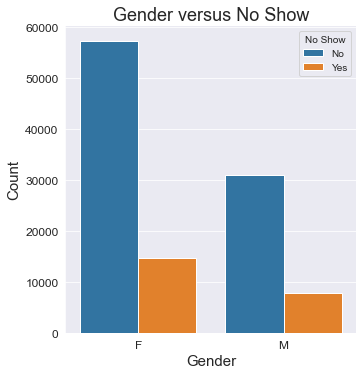

In [11]:
#Graph 1.1
sns.set_style('darkgrid')
plt.gcf().set_size_inches(20, 8);
sns.catplot(x='gender',hue='no_show',kind='count', data=df,legend=False);
plt.legend(title='No Show')
plt.xlabel('Gender', size=15)
plt.ylabel('Count', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Gender versus No Show', size=18)
plt.show();

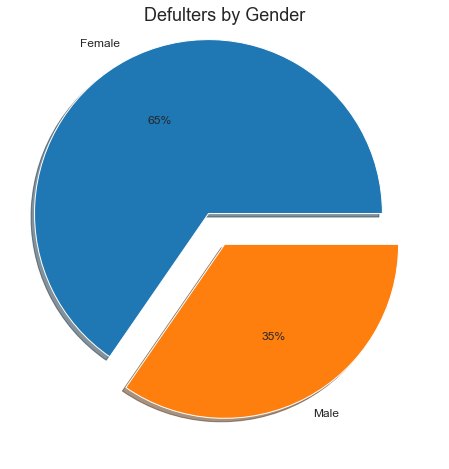

In [15]:
#Graph 1.2
#visualize what gender has highest number of defaulters 
sex=df.query('no_show=="Yes"').gender #select gender from appointment defaulters
plt.gcf().set_size_inches(20, 8)
explode=[0.2,0]
sex.value_counts().plot(kind='pie',autopct='%.0f%%',textprops={'size': 'large'},shadow=True, labels=["Female", "Male"],ylabel='', explode=explode)
plt.title('Defulters by Gender', size=18);
plt.show()

In [31]:
#use the custom function we created to create cross table and perform chi-square test
chi_square(df.gender, df.no_show)

no_show     No    Yes
gender               
F        57246  14594
M        30962   7725
The test p-value is 0.17338418189785987


The p-value is greater than 0.05 therefore we reject null hypothesis and conclude gender and showing up are not correlated. Gender is not useful in predicting the attendance.

## What day of the week has highest proportion of appointments?
Wednesday has the highest number of appointments, followed closely by Tuesday. Saturday has the least number of appointments, seems it's an idle day at the clinic. The management could use this information to plan and allocate human and other resources accordingly, for instance, this can guide on what day medics gets an off-day.

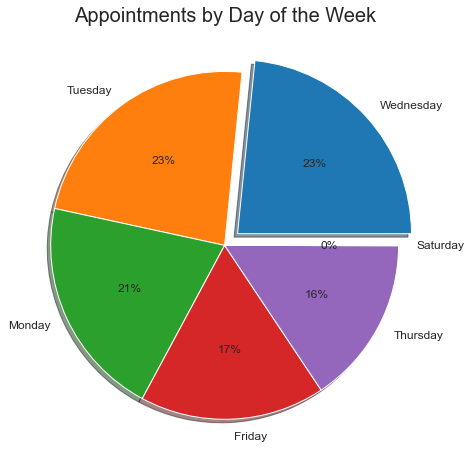

In [20]:
#Appointments by day of the week 
appointments=df.week_day
plt.gcf().set_size_inches(20, 8)
explode=(0.1, 0,0,0,0,0)
appointments.value_counts().plot(kind='pie',ylabel='',labels=appointments.value_counts().index ,autopct='%.0f%%',textprops={'size': 'large'},shadow=True,explode=explode);
plt.title('Appointments by Day of the Week', size=20)
plt.show()

## Does day of the week determine whether a patient will show up?

Chi-square test of indipendence point to a strong relationship between day of the week and attendance. The p-value is way less than 0.05 signaling a strong dependency. This is an important predictor of attendance. 

In [36]:
#use our custom function
chi_square(df.week_day, df.no_show)

no_show       No   Yes
week_day              
Friday     14982  4037
Monday     18025  4690
Saturday      30     9
Thursday   13909  3338
Tuesday    20488  5152
Wednesday  20774  5093
The test p-value is 4.622523600571694e-05


## Does attendance depend on age?

The p-value is way less than 0.05, this indicate that appointment attendance is different for  particular age group. Consequently, we conclude attendance strongly depend on a patient's age group or age. 

In [38]:
#use the custom function we created to create cross table and perform chi-square test
chi_square(df.age_grp, df.no_show)

no_show         No   Yes
age_grp                 
Children     18332  4926
Youth        10470  3540
Young Adult  12102  3634
Old Adult    36069  8153
Senior       11235  2066
The test p-value is 4.508797170407992e-125


# Visualize age versus attendance 
The old adult age group has more patients than other age groups. We can infer from the graph that in each age group less than 50% never showed up.

<Figure size 1296x576 with 0 Axes>

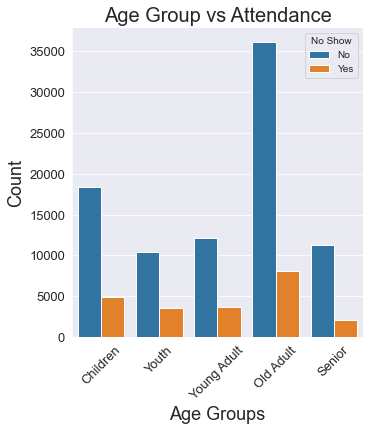

In [23]:
plt.gcf().set_size_inches(18, 8)
sns.catplot(x='age_grp',hue='no_show',kind='count', data=df, legend=False);
plt.legend(title='No Show')
plt.xlabel('Age Groups', size=18)
plt.title('Age Group vs Attendance', size=20)
plt.ylabel('Count', size=18)
plt.xticks(size=13, rotation=45) #tilt xtics 
plt.yticks(size=13)
plt.show()

## Visualizing sponsored versus Self-sponsored Patients 
Self-sponsored patients contribute 90 percent to the total sample. 

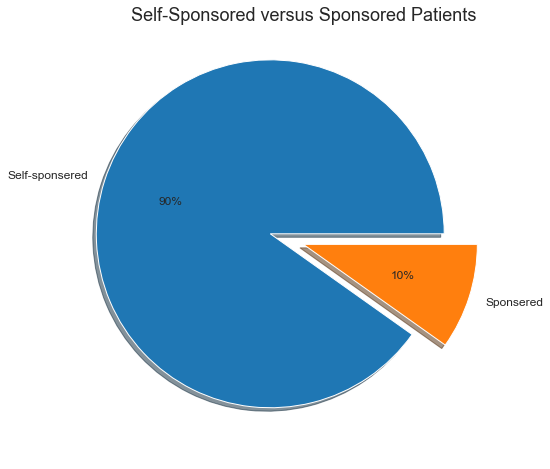

In [24]:
sp=df.scholarship
#props.index.map(labels) maps dummies with corresponding labels 
labels={0:'Self-sponsered',1:'Sponsered'}#we cannot use 1 and 0 as labels so we rename them first 
explode=(0.2, 0)
plt.gcf().set_size_inches(18, 8)
sp.value_counts().plot(kind='pie',ylabel='',labels=sp.index.map(labels) ,autopct='%.0f%%',textprops={'size': 'large'},shadow=True,explode=explode);
plt.title('Self-Sponsored versus Sponsored Patients', size=18)
plt.show()

## Visualize sponsored patients versus attendance
Patients with a scholarship are less than self-sponsored patients. Checking from the sponsored group, 76 percent showed up.

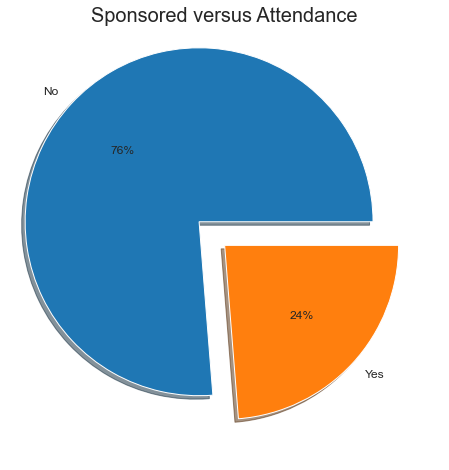

In [65]:
sponsored=df.query('scholarship==1').no_show
#props.index.map(labels) maps dummies with corresponding labels 
#labels={0:'Self-sponsered',1:'Sponsered'}#we cannot use 1 and 0 as labels so we rename them first 
props=sponsored.value_counts()
explode=(0.2, 0)
plt.gcf().set_size_inches(18, 8)
sponsored.value_counts().plot(kind='pie',ylabel='',labels=props.index ,autopct='%.0f%%',textprops={'size': 'large'},shadow=True,explode=explode);
plt.title('Sponsored versus Attendance', size=20)
plt.show()

## Does having a scholarship motivate patients to show up for appointment?
A chi-square test of indipendence was conducted to check whether having a scholarship or not determines whether a patient will attend or not.

The p-value 3.906624913845394e-22 is way less than 0.05 therefore we do not reject H0 and conclude there is a strong correlation between having a scholarship and showing up for the doctor's appointment. This is an important factor in predicting appointment attendance. 

In [39]:
#use the custom function we created to create cross table and perform chi-square test
chi_square(df.scholarship, df.no_show)

no_show         No    Yes
scholarship              
0            79925  19741
1             8283   2578
The test p-value is 3.906624913845394e-22


## What month has the largest proportion of appointments?
Assumption: The study was conducted for the entire month for each of the 3 months. 
The month of April has the least number of appointments, followed by June. Majority of the appointments were scheduled for the month of May. In fact, the month of may has more appointments than April and June combined. 


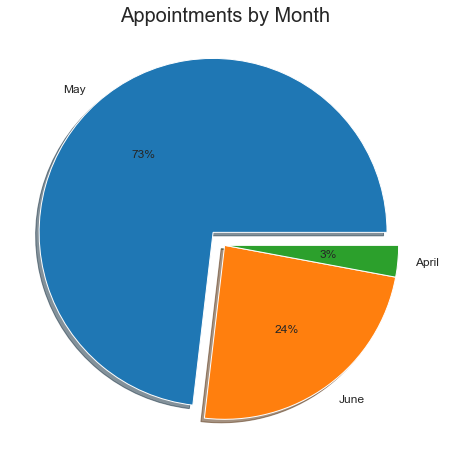

In [25]:
#month with the highest proportion of appointments 
month=df.month
explode=(0.1, 0,0)
plt.gcf().set_size_inches(18, 8)
month.value_counts().plot(kind='pie',ylabel='',labels=month.value_counts().index ,autopct='%.0f%%',textprops={'size': 'large'},shadow=True,explode=explode);
plt.title('Appointments by Month', size=20)
plt.show()

## Does appointment month influence attendance?
Pause: Are these observations different for a particular month? Is there dependence between appointment month and attendance? 

The test p-value 1.7727517737147313e-15 is way below zero and less than 0.05, therefore we confidently conclude observations from a particular month are indeed different. Consequently, we confirm there is a correlation between appointment month and a patient showing up. This is an important predictor. 

In [40]:
#use the custom function we created to create cross table and perform chi-square test
chi_square(df.month, df.no_show)

no_show     No    Yes
month                
April     2602    633
June     21569   4882
May      64037  16804
The test p-value is 1.7727517737147313e-15


## Visualize Alcoholism Gender and Diabetes
No alcoholism is observed from the diabetic group for both gender. Alcoholism is relatively low in the non-diabetic group for both gender. However, there were more men than women in alcoholism. Interesting !! 

<Figure size 1296x576 with 0 Axes>

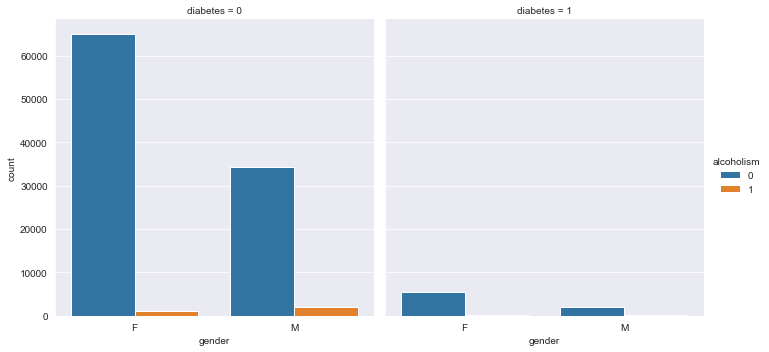

In [29]:
plt.gcf().set_size_inches(18,8)
sns.catplot(x='gender', hue='alcoholism', col='diabetes',kind='count',data=df, legend=True,
           legend_out=True, sharex=True, sharey=True);

## Is there a relationship between alcoholism and attendance variable?
Chi-square test of indipendence indicate there is no relationship between alcoholism and attendance. Therefore, alcoholism is not important in predicting whether a patient will show up for appointment. 

In [41]:
#use the custom function we created to create cross table and perform chi-square test
chi_square(df.alcoholism, df.no_show)

no_show        No    Yes
alcoholism              
0           85525  21642
1            2683    677
The test p-value is 0.9654188731603915


The p-value is greater than 0.05 therefore we reject H0 hypoyhesis and conclude alcoholism and showing up are not correlated. 

## Does being diabetic influence attendance?
Yes, there is a strong dependency between diabetes and attendance. The p-value is less than 0.05 therefore we reject the null hypothesis and conclude diabetic and non-diabetic patients behave differently. simply put , attendance is dependent on a person being diabetic or not. A diabetic person will be more careful with the doctor's appointment. 

In [42]:
#use the custom function we created to create cross table and perform chi-square test
chi_square(df.diabetes, df.no_show)

no_show      No    Yes
diabetes              
0         81695  20889
1          6513   1430
The test p-value is 4.849904575233736e-07


## Does attendance depend on being handcap?
The p-value is greater than 0.05 and confirms there is no correlation between attendance and a patient being handcap. consequently, this variable is not important in predicting whether a patient will default appointment or not. 

In [43]:
#use the custom function we created to create cross table and perform chi-square test
chi_square(df.handcap, df.no_show)

no_show     No    Yes
handcap              
0        86374  21912
1         1676    366
2          146     37
3           10      3
4            2      1
The test p-value is 0.1340718823629825


# Conclusion

In this project, useful insights were derived from the medical appointmment data. This information could guide the hospital's stakeholders strategize how to lower number of appointment defaulters, and identify what factors determine whether a person will show up. 

Three new variables were created from the original variables through feature engineering. All the new variables were found to be good predictors of attendance and could improve any predictive model that was built with the original variables only.

Besides, other important variables for prediction were indentified. These factors will come in handy in the next phase of this case study, that is predictive modelling. Apart from this project's approach to identify important predictors,a base machine learning model would really fasten identifying and ranking features by their contribution to prediction accuracy score.

### Limitations:
The handcap variable is not well described, what each numerical value means. Besides, handcap was presented as on ordinal variable instead of nominal variable. This implies that handcap =1 is greater than handcap=0 and so on. We also don't know what these levels mean. 


 #   END                            